In [1]:
%load_ext autoreload
%autoreload 2

import analysis
import plots
import runner
import numpy as np
from utils import generate_ou_input


# Exploration of variations of noise input 


In [2]:
params = dict()
params['runtime'] = 400
params['min_dt'] = 0.05
params['ou_stationary'] = True

def plot_ou_noise(params: dict):
    mean = generate_ou_input(params['runtime'], params['min_dt'], params['ou_stationary'], params['ou_mu'])
    sigma = generate_ou_input(params['runtime'], params['min_dt'], params['ou_stationary'], params['ou_sigma'])
    plots.noise(mean, sigma, save=False)

### Weak Correlation - Default Configuration

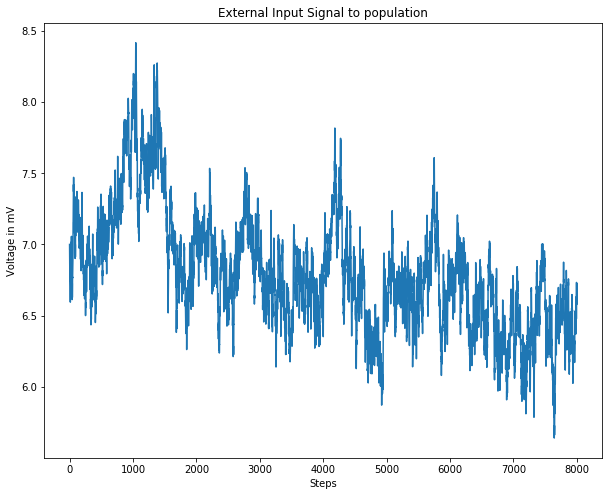

In [3]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 50.
}

# noise params for sigma
params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

plot_ou_noise(params)

### Medium Correlation - Default Configuration

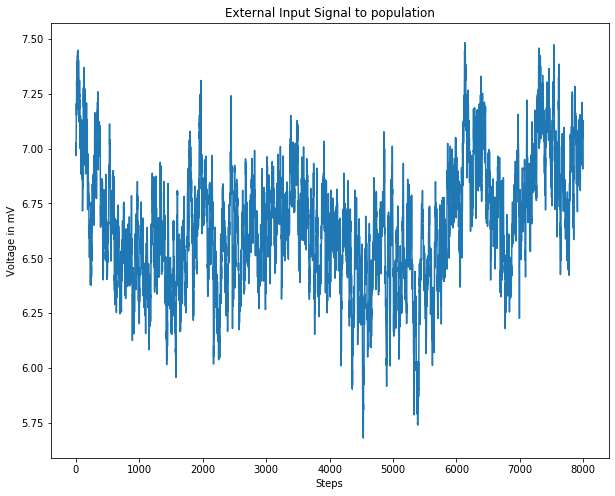

In [4]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 500.
}

# noise params for sigma
params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

plot_ou_noise(params)

### Very Strong Correlation over Time

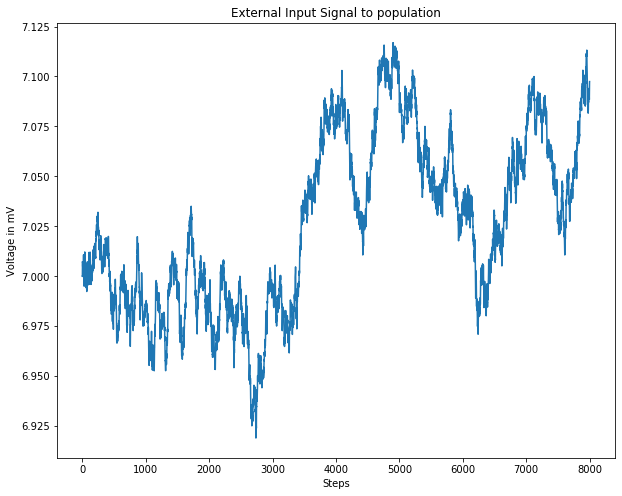

In [9]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 5000.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 10000.
}

plot_ou_noise(params)

In [29]:
results = runner.run("strong_correlation", modified_params=params)

building synapses...
build synapses time: 0.4269120693206787s
------------------ running network!
runtime: 14.4


[Errno 17] File exists: 'plots/strong_correlation'
Generate PSD plot ...
Generate PSD plot ...


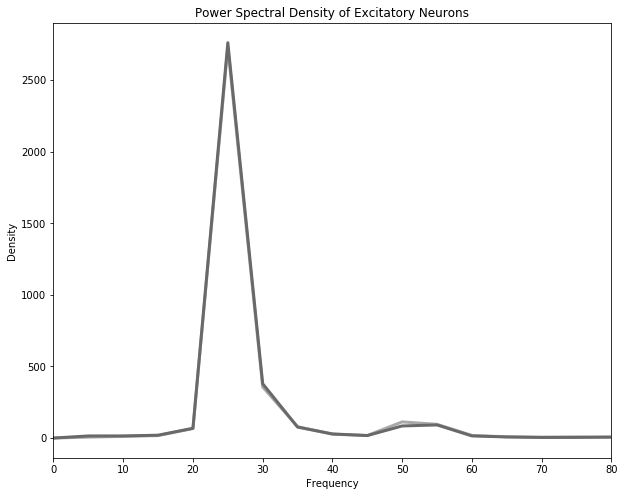

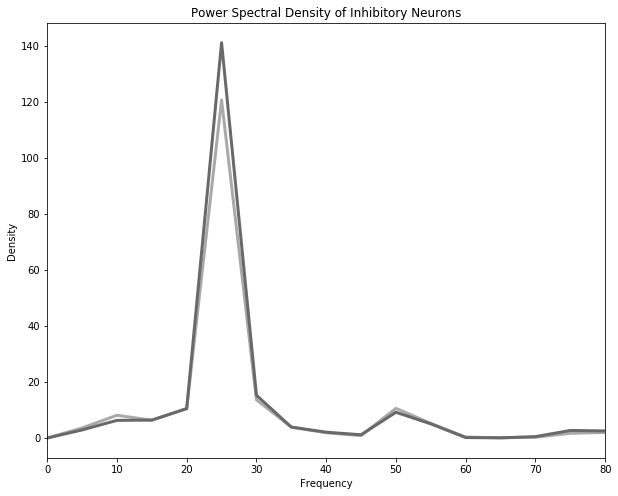

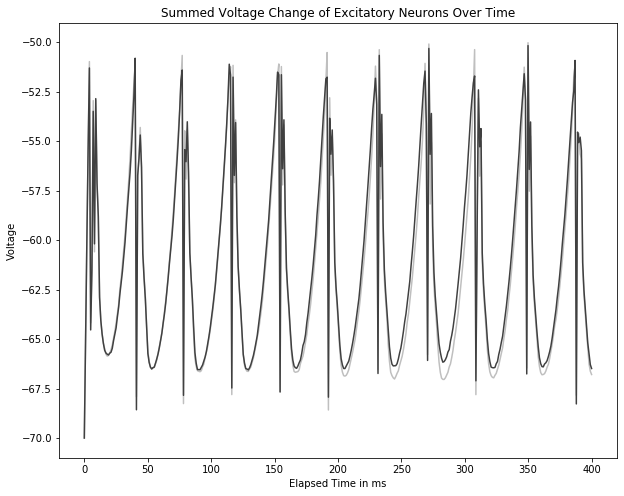

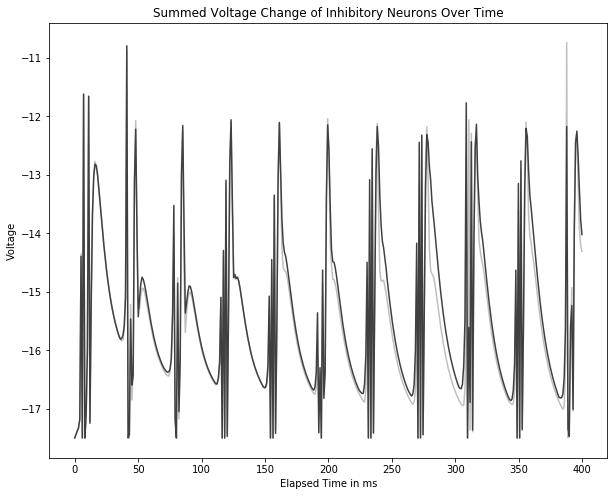

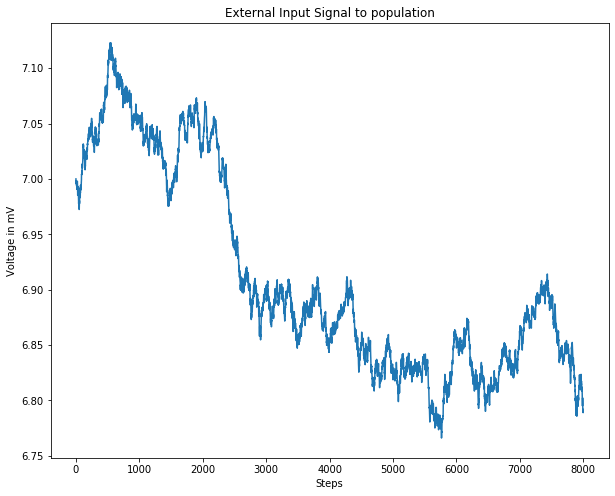

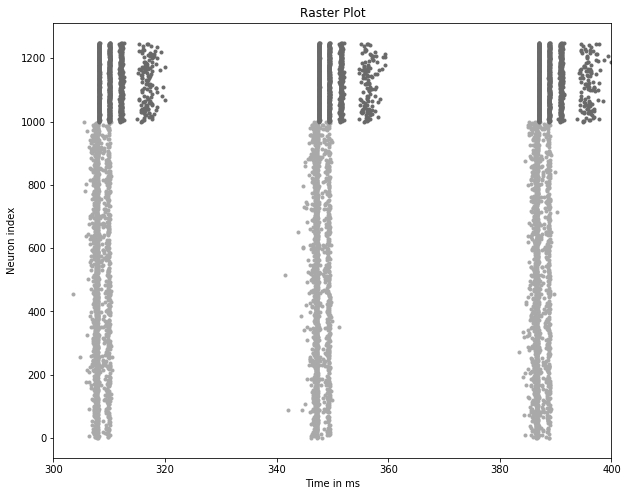

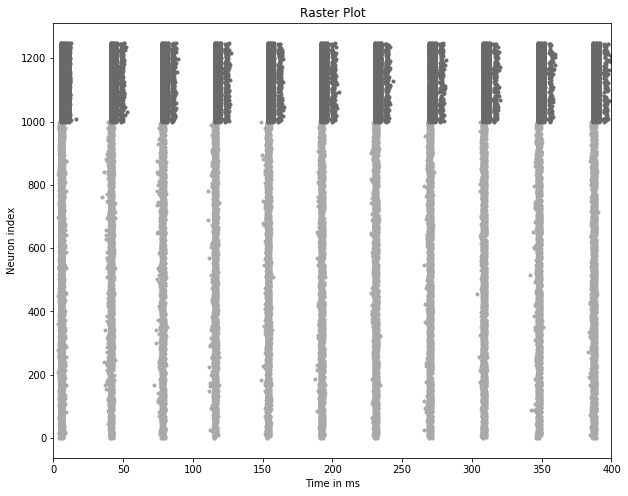

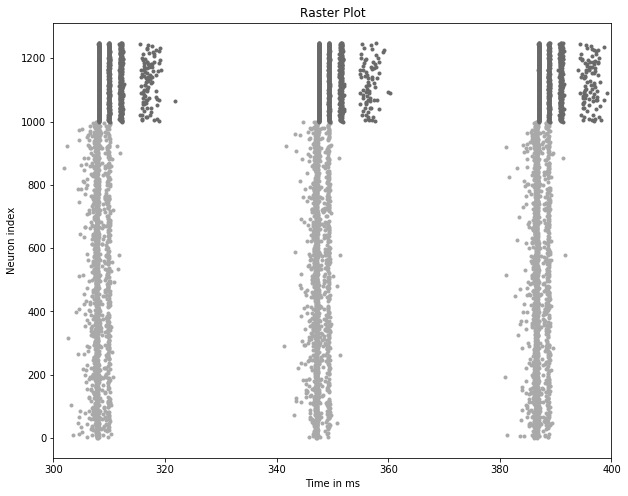

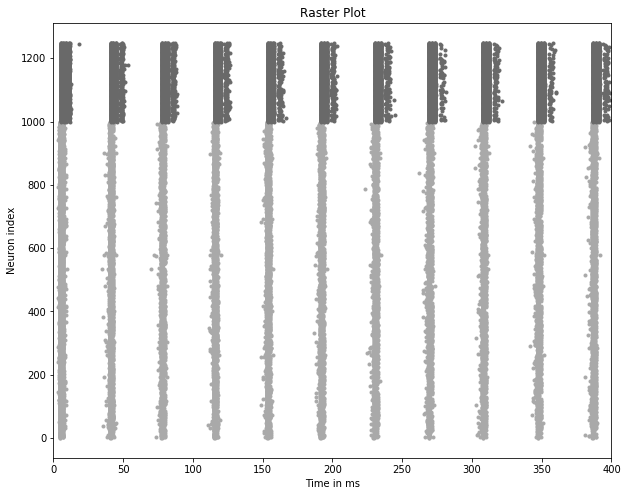

In [30]:
analysis.analyze_model(results, 'strong_correlation')

### Gaussian white noise (no correlation $\tau$ = 1)

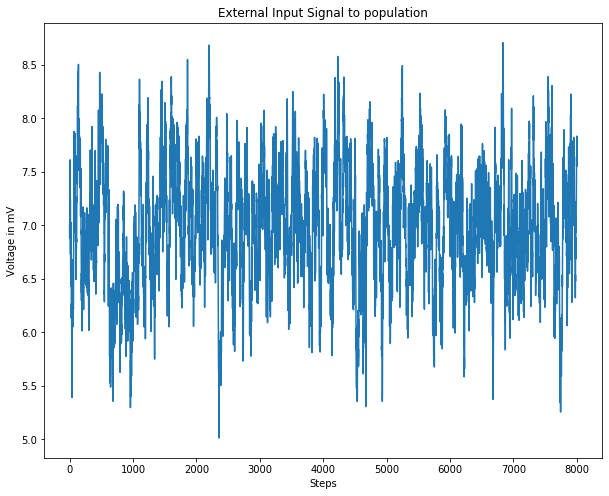

In [31]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 1.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

plot_ou_noise(params)


In [32]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': .5,
    'ou_tau': 1.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 0.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

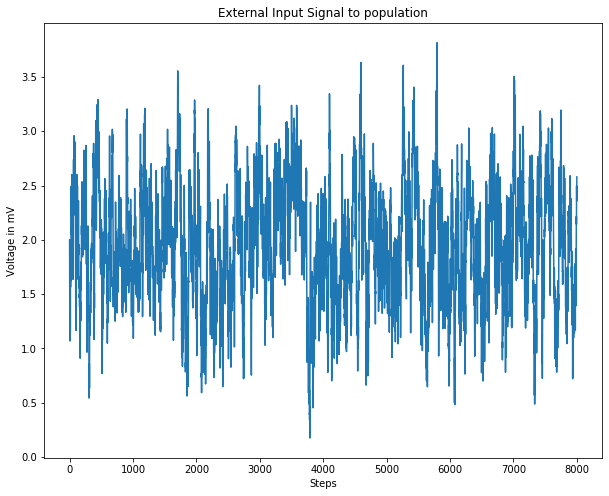

In [33]:
plot_ou_noise(params)

In [34]:
results = runner.run("low_strength", modified_params=params)

building synapses...
build synapses time: 0.426347017288208s
------------------ running network!
runtime: 14.6


[Errno 17] File exists: 'plots/low_strength'
Generate PSD plot ...
Generate PSD plot ...


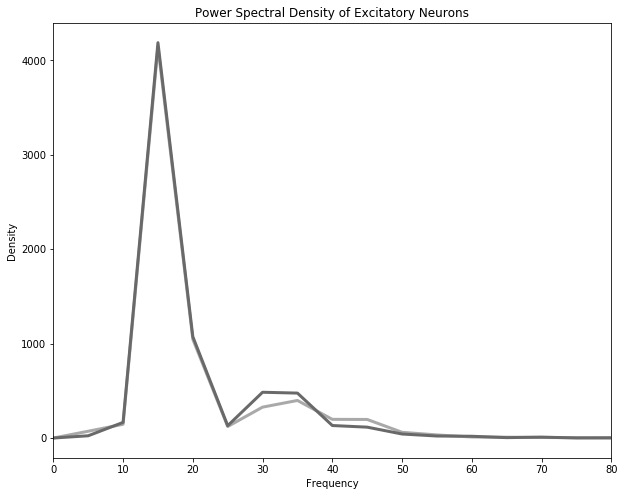

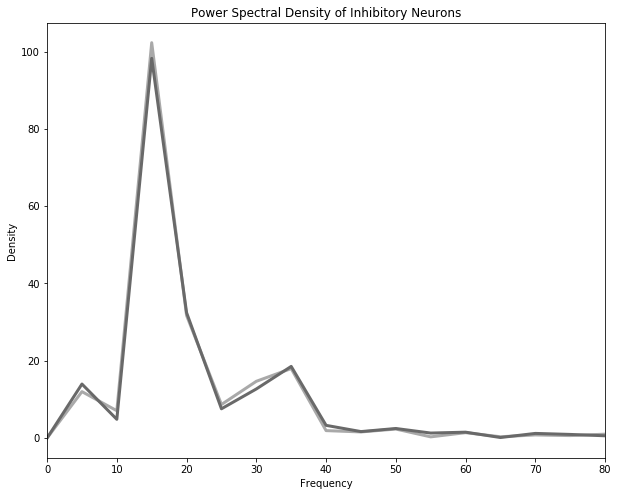

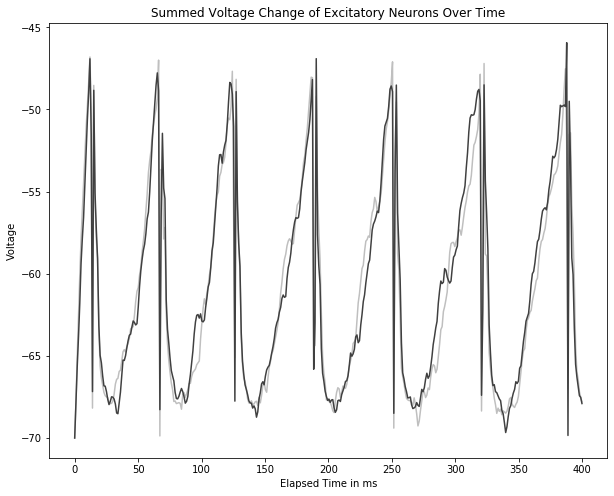

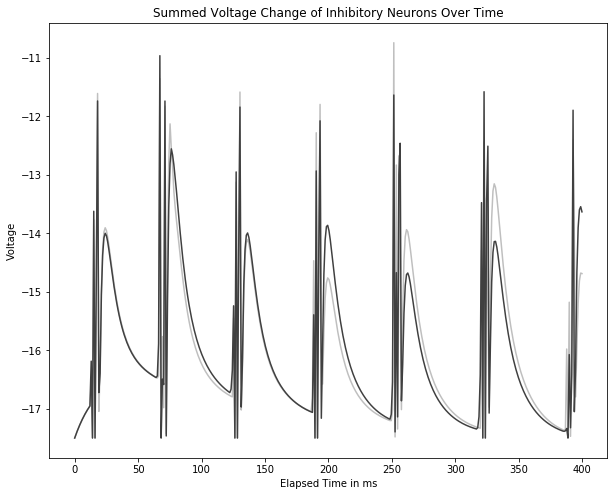

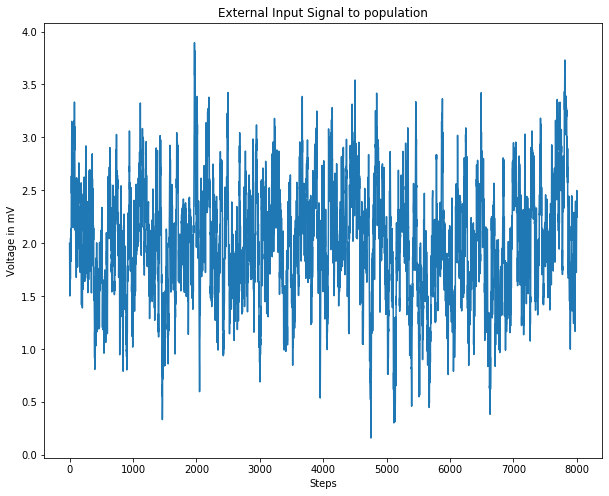

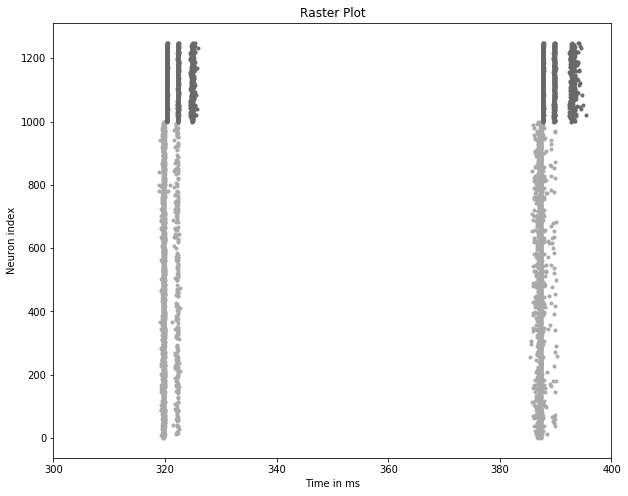

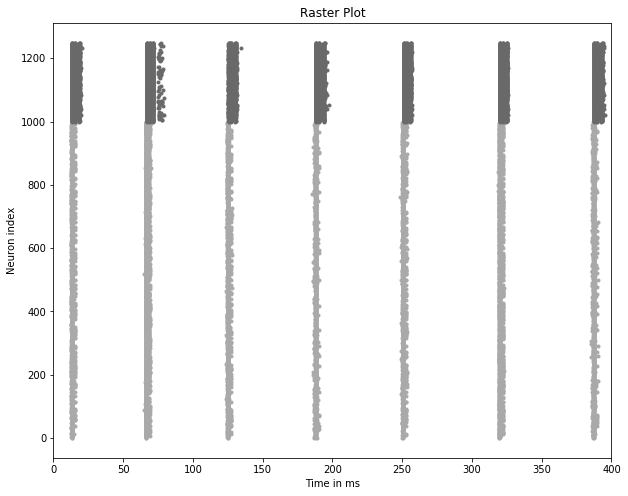

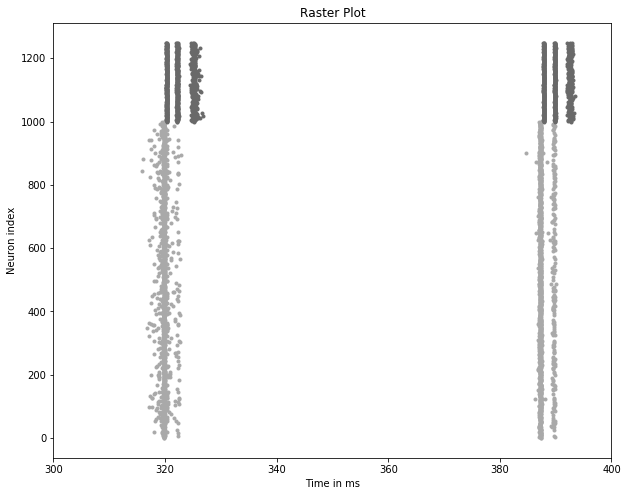

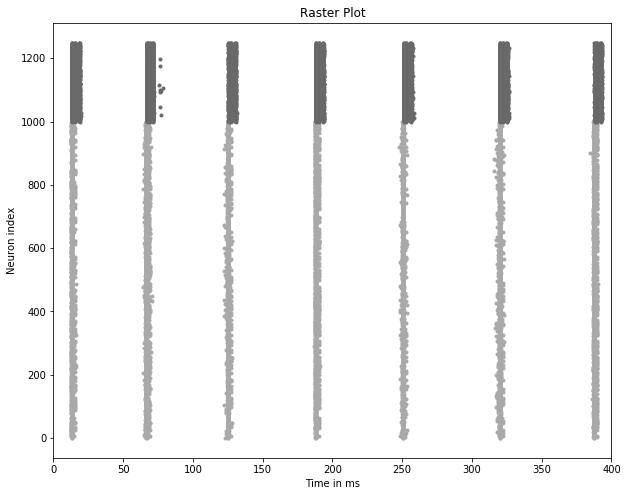

In [35]:
analysis.analyze_model(results, 'low_strength')

Varying the mean ("strength") of the noise.

Expectation: increase and decrease in frequency.

Setup:
* parameter range for mean
* run for each model
* for each model we need the raster plot and the psd plot of one population

Extend simulation

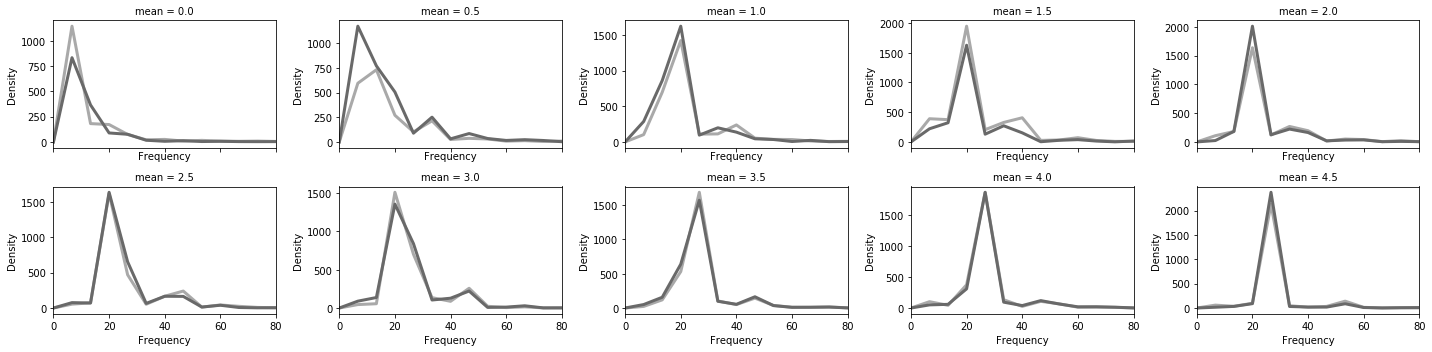

In [3]:
models = analysis.load([str(el) for el in np.arange(0, 5, 0.5)])
plots.all_psd(models=models, n_cols=2, n_rows=5)
